In [23]:
#standard packages
import numpy as np
from numpy import concatenate
import pandas as pd
import glob
import math
import warnings

#plot packages
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

#package to create date-time objects
import datetime as dt

#performance measures
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

from timeit import default_timer as timer
from datetime import timedelta
import tensorflow as tf
from tqdm import tqdm
from IPython.utils import io

import warnings
warnings.filterwarnings("ignore")

def _naive_forecasting(actual: np.ndarray, seasonality):
    return actual[:-seasonality]

def _naive_forecasting_test(actual: np.ndarray, seasonality, test):
    forecast=[]
    for j in range(0, len(test), seasonality):
        forecast.append(actual[-seasonality:])
    forecast = [item for sublist in forecast for item in sublist]
    return forecast[:len(test)]

def mean_absolute_scaled_error(actual: np.ndarray, predicted: np.ndarray, seasonality):
    #Baseline (benchmark) is computed with naive forecasting shifted bu seasonality
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual[seasonality:], _naive_forecasting(actual, seasonality))

def mean_absolute_scaled_error_test(actual: np.ndarray, predicted: np.ndarray, seasonality, actual_train):
    #Baseline (benchmark) is computed with naive forecasting shifted bu seasonality
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual, _naive_forecasting_test(actual_train, seasonality, actual))

def mean_absolute_scaled_error_test2(actual: np.ndarray, predicted: np.ndarray, seasonality, actual_train):
    #Baseline (benchmark) is computed with naive forecasting shifted bu seasonality
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual_train[seasonality:], _naive_forecasting(actual_train, seasonality))

def mean_directional_accuracy(y, y_hat):
    #Mean Directional Accuracy
    return np.mean(np.sign(y.diff()[1:]) == np.sign(y_hat.diff()[1:]))
    # the reason the two diffrence are diffrentely computed is because y is inputed as dataframe column but yhat is a array. 
    #If this is diffrent then change.
    
#RF packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn import tree

pd.options.mode.chained_assignment = None  # default='warn'
# import random 
import random

#prophet packages
from prophet import Prophet

#LSTM packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#SARIMAX packages
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm                       
import warnings
from itertools import product
from tqdm import tqdm_notebook

import seaborn as sns

In [2]:
def ArimaModel_multivariate(df, len_trainset):
    df= df.reset_index(drop=True)
    train = df[:len_trainset]
    test = df[len_trainset:]
    
    start = timer()
    sxmodel = pm.auto_arima(train[['y']], exog = train[['irregular', 'holiday', 'DeliverD1', 'DeliverD7', 'DeliverD14', 'DeliverD21', 'Bill1', 'Bill7', 'Bill14', 'Bill21','Deliver']],
                           start_p=4, start_q=0,
                           start_P=2, start_Q=0,
                           test='adf',
                           m=24,seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

    sxmodel.summary()
    end = timer()
    runtime = end-start
    print(round(runtime, 4))
    
    
    forecast = sxmodel.predict(n_periods=len(test), exog=test[['irregular', 'holiday', 'DeliverD1', 'DeliverD7',
       'DeliverD14', 'DeliverD21', 'Bill1', 'Bill7', 'Bill14', 'Bill21',
       'Deliver']])
    pred = sxmodel.fittedvalues()
    
    prediction = pd.concat([pred, forecast])

    results = pd.concat((df[['ds', 'y']].reset_index(drop=True),pd.DataFrame(data = {'Forecast': prediction})), axis=1)
    return results

In [6]:
df = pd.read_csv(r'C:\Users\Britt\Documents\DataAnalyse\data\half_hour.txt', sep="\t")
df.date = pd.date_range(df.date[0] , periods = len(df.date), freq='30min')
df.rename(columns={'date' : 'ds', 'count' : 'y'}, inplace=True)
df.drop(['AvgService'], axis=1, inplace=True)

In [7]:
sns.set_style("darkgrid")

In [8]:
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True)

In [9]:
dfArima=pd.DataFrame(columns=df.columns)
dfArima=dfArima.drop('kperiod', axis = 1)
dfArima['y']=df.resample('H').sum().y
dfArima[['irregular', 'holiday', 'DeliverD1', 'DeliverD7',
       'DeliverD14', 'DeliverD21', 'Bill1', 'Bill7', 'Bill14', 'Bill21',
       'Deliver']]=df.resample('H').last()[['irregular', 'holiday', 'DeliverD1', 'DeliverD7',
       'DeliverD14', 'DeliverD21', 'Bill1', 'Bill7', 'Bill14', 'Bill21',
       'Deliver']]

In [10]:
df= df.reset_index()
dfArima= dfArima.reset_index()

In [11]:
len_trainset=round(0.8*len(dfArima))
train = dfArima[:len_trainset]
test = dfArima[len_trainset:]

In [14]:
results_arima = ArimaModel_multivariate(dfArima, len_trainset)

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [25]:
start = timer()
model=SARIMAX(train[['y']],order=(5, 0, 1),seasonal_order=(2,1,0,24), exog = train[['irregular', 'holiday', 'DeliverD1', 'DeliverD7','DeliverD14', 'DeliverD21', 'Bill1', 'Bill7', 'Bill14', 'Bill21','Deliver']])
results=model.fit(maxiter=50)
end = timer()
runtime = end-start

In [26]:
print(runtime)

3901.0072310000005


In [144]:
forecast= results.forecast(steps=len(test), exog=test[['irregular', 'holiday', 'DeliverD1', 'DeliverD7',
       'DeliverD14', 'DeliverD21', 'Bill1', 'Bill7', 'Bill14', 'Bill21',
       'Deliver']])

In [145]:
pred = results.predict()

In [146]:
prediction = pd.concat([pred, forecast])

In [147]:
prediction[1:]

1         9.448610
2        13.225739
3        13.798135
4        14.183158
5        12.505610
           ...    
7723    862.504623
7724    794.480295
7725    704.597098
7726    541.399665
7727    375.425851
Name: predicted_mean, Length: 7727, dtype: float64

In [148]:
dfArima

,ds,irregular,holiday,y,DeliverD1,DeliverD7,DeliverD14,DeliverD21,Bill1,Bill7,Bill14,Bill21,Deliver
0,2004-02-14 00:00:00,0,0,118,0,0,0,0,0,0,0,0,0
1,2004-02-14 01:00:00,0,0,70,0,0,0,0,0,0,0,0,0
2,2004-02-14 02:00:00,0,0,39,0,0,0,0,0,0,0,0,0
3,2004-02-14 03:00:00,0,0,42,0,0,0,0,0,0,0,0,0
4,2004-02-14 04:00:00,0,0,16,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,2004-12-31 19:00:00,0,0,308,0,0,0,0,0,0,0,0,0
7724,2004-12-31 20:00:00,0,0,249,0,0,0,0,0,0,0,0,0
7725,2004-12-31 21:00:00,0,0,234,0,0,0,0,0,0,0,0,0
7726,2004-12-31 22:00:00,0,0,190,0,0,0,0,0,0,0,0,0


In [149]:
results_arima = pd.concat((dfArima[['ds', 'y']].reset_index(drop=True),pd.DataFrame(data = {'Forecast': prediction})), axis=1)

In [150]:
results_arima

,ds,y,Forecast
0,2004-02-14 00:00:00,118,0.000000
1,2004-02-14 01:00:00,70,9.448610
2,2004-02-14 02:00:00,39,13.225739
3,2004-02-14 03:00:00,42,13.798135
4,2004-02-14 04:00:00,16,14.183158
...,...,...,...
7723,2004-12-31 19:00:00,308,862.504623
7724,2004-12-31 20:00:00,249,794.480295
7725,2004-12-31 21:00:00,234,704.597098
7726,2004-12-31 22:00:00,190,541.399665


In [151]:
results_arima.to_csv(r'C:\Users\Britt\Documents\DataAnalyse\data\callcenter_arima_results.txt', index=False)

In [12]:
results_arima = pd.read_csv(r'C:\Users\Britt\Documents\DataAnalyse\data\callcenter_arima_results.txt', sep=",")

In [13]:
results_arima

,ds,y,Forecast
0,2004-02-14 00:00:00,118,0.000000
1,2004-02-14 01:00:00,70,9.448610
2,2004-02-14 02:00:00,39,13.225739
3,2004-02-14 03:00:00,42,13.798135
4,2004-02-14 04:00:00,16,14.183158
...,...,...,...
7723,2004-12-31 19:00:00,308,862.504623
7724,2004-12-31 20:00:00,249,794.480295
7725,2004-12-31 21:00:00,234,704.597098
7726,2004-12-31 22:00:00,190,541.399665


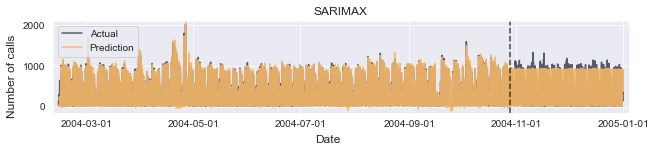

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, constrained_layout=True, figsize=(9, 2))

ax.set_title('SARIMAX')
ax.plot(np.asarray(results_arima.ds, dtype='datetime64[s]'), results_arima.y, color= '#555B6E', label = 'Actual')
# Plot the predicted values
ax.plot(np.asarray(results_arima.ds, dtype='datetime64[s]'), results_arima.Forecast, label = 'Prediction', alpha=0.9, color= '#F3B768')
ax.axvline(x=np.asarray(results_arima.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
ax.margins(x=0.01)
ax.margins(y=0.02)
ax.legend(loc="upper left")

fig.supxlabel('Date')
fig.supylabel('Number of calls')

ax.set_xticks(ax.get_xticks()[::2])

plt.savefig(r'C:\Users\Britt\Documents\callcenter_results_overall_arima.pdf', format="pdf", bbox_inches="tight")  

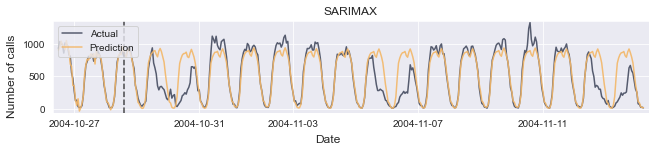

In [18]:
zoom1 = 50 #amount of observation from the train set you see
zoom2 = 400  #amount of observation from test you see
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True,  constrained_layout=True, figsize=(9, 2))

ax.set_title('SARIMAX')
ax.plot(np.asarray(results_arima.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], results_arima.y[len_trainset-zoom1:len_trainset+zoom2], color= '#555B6E', label = 'Actual')
# Plot the predicted values
ax.plot(np.asarray(results_arima.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], results_arima.Forecast[len_trainset-zoom1:len_trainset+zoom2], label = 'Prediction', alpha=0.9, color= '#F3B768')
ax.axvline(x=np.asarray(results_arima.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
ax.margins(x=0.01)
ax.margins(y=0.02)
ax.legend(loc="upper left")
fig.supxlabel('Date')
fig.supylabel('Number of calls')

ax.set_xticks(ax.get_xticks()[::2])

plt.savefig(r'C:\Users\Britt\Documents\callcenter_results_zoom_arima.pdf', format="pdf", bbox_inches="tight")  

In [88]:
results_refit = results

In [89]:
forecast=[]
for i in tqdm(range(0, len(test), 10)):
    forecast1 = results_refit.forecast(steps=10, exog=test[['irregular', 'holiday', 'DeliverD1', 'DeliverD7',
       'DeliverD14', 'DeliverD21', 'Bill1', 'Bill7', 'Bill14', 'Bill21',
       'Deliver']].iloc[i:i+10])
    results_refit = results_refit.append(test[['y']].iloc[i:i+10], exog=test[['irregular', 'holiday', 'DeliverD1', 'DeliverD7',
       'DeliverD14', 'DeliverD21', 'Bill1', 'Bill7', 'Bill14', 'Bill21',
       'Deliver']].iloc[i:i+10], refit=True, maxiter=20)
    forecast.append(forecast1)

 99%|████████████████████████████████████████████████████████████████████████████▌| 154/155 [9:41:42<03:46, 226.64s/it]


ValueError: Provided exogenous values are not of the appropriate shape. Required (10, 11), got (6, 11).

In [90]:
forecast1

7712    415.643791
7713    621.237212
7714    745.077707
7715    824.843131
7716    858.203487
7717    828.525279
7718    835.826060
7719    793.071452
7720    868.422427
7721    933.844337
Name: predicted_mean, dtype: float64

SyntaxError: invalid syntax (764623079.py, line 3)

In [91]:
pred = results.predict()

In [94]:
forecast

[6182    884.706001
 6183    828.239384
 6184    797.121701
 6185    895.975630
 6186    922.439582
 6187    851.931453
 6188    787.472070
 6189    700.013160
 6190    538.688985
 6191    373.275151
 Name: predicted_mean, dtype: float64,
 6192    217.146173
 6193     66.292140
 6194     39.279162
 6195     -9.281803
 6196    -32.852425
 6197    -27.246585
 6198     24.656062
 6199    158.766641
 6200    445.082930
 6201    680.304360
 Name: predicted_mean, dtype: float64,
 6202    692.940426
 6203    749.224381
 6204    777.161365
 6205    810.219890
 6206    801.544560
 6207    774.912616
 6208    755.412822
 6209    863.214392
 6210    882.516112
 6211    885.306451
 Name: predicted_mean, dtype: float64,
 6212    275.703050
 6213    233.854127
 6214    147.889830
 6215     18.270445
 6216    -34.884868
 6217   -114.943097
 6218    -97.125660
 6219   -119.293984
 6220    -91.421230
 6221    -49.911801
 Name: predicted_mean, dtype: float64,
 6222    247.330214
 6223    327.335329
 622

In [92]:
forecast2 = pd.DataFrame([item.tolist() for item in forecast])

In [93]:
forecast

,0,1,2,3,4,5,6,7,8,9
0,884.706001,828.239384,797.121701,895.975630,922.439582,851.931453,787.472070,700.013160,538.688985,373.275151
1,217.146173,66.292140,39.279162,-9.281803,-32.852425,-27.246585,24.656062,158.766641,445.082930,680.304360
2,692.940426,749.224381,777.161365,810.219890,801.544560,774.912616,755.412822,863.214392,882.516112,885.306451
3,275.703050,233.854127,147.889830,18.270445,-34.884868,-114.943097,-97.125660,-119.293984,-91.421230,-49.911801
4,247.330214,327.335329,581.262335,796.562434,867.886028,921.427425,949.512874,843.926758,795.425997,720.929365
...,...,...,...,...,...,...,...,...,...,...
149,884.047818,945.032398,926.355468,899.366130,784.690160,637.933977,493.702903,312.179181,183.599241,72.111660
150,77.214807,65.624591,51.147893,53.852757,73.723416,201.288236,472.667389,686.862145,787.853723,857.819590
151,936.084378,970.082671,906.291328,873.705887,912.664925,976.936046,996.801463,965.685701,823.656049,672.053110
152,531.680353,334.074173,242.745783,128.413146,73.963627,47.550019,35.639378,37.335678,62.485174,190.464265


In [106]:
forecast3 = forecast2.iloc[0]
for i in range(1,len(forecast2)):
    forecast3 = pd.concat([forecast3, forecast2.iloc[i]], axis='rows')

In [109]:
pd.DataFrame(forecast3)

,0
0,884.706001
1,828.239384
2,797.121701
3,895.975630
4,922.439582
...,...
5,828.525279
6,835.826060
7,793.071452
8,868.422427


In [112]:
prediction = pd.concat([pred, forecast3]).reset_index(drop=True)

In [120]:
prediction = pd.DataFrame(prediction)

In [121]:
prediction.columns =['Forecast']

In [123]:
results_arima2 = pd.concat((dfArima[['ds', 'y']].reset_index(drop=True),prediction), axis=1)

In [132]:
results_arima2 = results_arima2.dropna()

In [154]:
results_arima2.to_csv(r'C:\Users\Britt\Documents\DataAnalyse\data\callcenter_arima_resultsOneStep.txt', index=False)

In [20]:
results_arima2 = pd.read_csv(r'C:\Users\Britt\Documents\DataAnalyse\data\callcenter_arima_resultsOnestep.txt', sep=",")

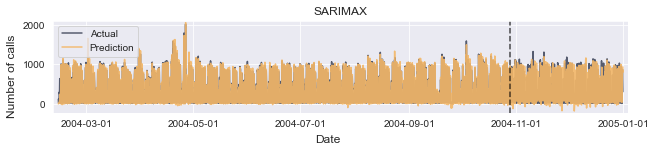

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, constrained_layout=True, figsize=(9, 2))

ax.set_title('SARIMAX')
ax.plot(np.asarray(results_arima2.ds, dtype='datetime64[s]'), results_arima2.y, color= '#555B6E', label = 'Actual')
# Plot the predicted values
ax.plot(np.asarray(results_arima2.ds, dtype='datetime64[s]'), results_arima2.Forecast, label = 'Prediction', alpha=0.9, color= '#F3B768')
ax.axvline(x=np.asarray(results_arima2.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
ax.margins(x=0.01)
ax.margins(y=0.02)
ax.legend(loc="upper left")

ax.set_xticks(ax.get_xticks()[::2])

fig.supxlabel('Date')
fig.supylabel('Number of calls')


plt.savefig(r'C:\Users\Britt\Documents\callcenter_results_overall_arima_onestep.pdf', format="pdf", bbox_inches="tight")

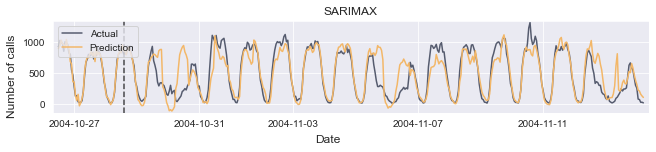

In [22]:
zoom1 = 50 #amount of observation from the train set you see
zoom2 = 400  #amount of observation from test you see
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True,  constrained_layout=True, figsize=(9, 2))

ax.set_title('SARIMAX')
ax.plot(np.asarray(results_arima2.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], results_arima2.y[len_trainset-zoom1:len_trainset+zoom2], color= '#555B6E', label = 'Actual')
# Plot the predicted values
ax.plot(np.asarray(results_arima2.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], results_arima2.Forecast[len_trainset-zoom1:len_trainset+zoom2], label = 'Prediction', alpha=1, color= '#F3B768')
ax.axvline(x=np.asarray(results_arima2.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
ax.margins(x=0.01)
ax.margins(y=0.02)
ax.legend(loc="upper left")

ax.set_xticks(ax.get_xticks()[::2])

fig.supxlabel('Date')
fig.supylabel('Number of calls')

plt.savefig(r'C:\Users\Britt\Documents\callcenter_results_zoom_arima_onestep.pdf', format="pdf", bbox_inches="tight")  

In [24]:
def preformance_measures(pred, len_trainset, S):
    y_true_train = pred.y[:len_trainset]
    y_true_test = pred.y[len_trainset:]
    y_pred_train = pred.Forecast[:len_trainset]
    y_pred_test = pred.Forecast[len_trainset:]

    MAEtrain = mean_absolute_error(y_true_train, y_pred_train)
    MAEtest = mean_absolute_error(y_true_test, y_pred_test)
    
    RMSEtrain = mean_squared_error(y_true_train, y_pred_train, squared=False)
    RMSEtest = mean_squared_error(y_true_test, y_pred_test, squared=False)

    MedAEtrain = median_absolute_error(y_true_train, y_pred_train)
    MedAEtest = median_absolute_error(y_true_test, y_pred_test)

    MASEtrain = mean_absolute_scaled_error(y_true_train, y_pred_train, S)
    MASEtest = mean_absolute_scaled_error_test2(y_true_test, y_pred_test, S, y_true_train)
        
    MDAtrain = mean_directional_accuracy(y_true_train, y_pred_train)
    MDAtest= mean_directional_accuracy(y_true_test, y_pred_test)

    results=[]
    results = pd.DataFrame(data= {'MEA': [round(MAEtrain, 3), round(MAEtest,3)],
                                  ' RMSE': [round(RMSEtrain, 3), round(RMSEtest,3)],
                                    'MedAE': [round(MedAEtrain, 3), round(MedAEtest,3)],
                                    'MASE': [round(MASEtrain, 3), round(MASEtest,3)],
                                    'MDA': [round(MDAtrain, 3), round(MDAtest,3)],})
    
    return results

In [25]:
print(preformance_measures(results_arima, len_trainset, 48))

       MEA     RMSE   MedAE   MASE    MDA
0   56.166   82.545  38.834  0.275  0.692
1  114.014  196.083  51.263  0.557  0.817


In [26]:
print(preformance_measures(results_arima2, len_trainset, 48))

       MEA     RMSE   MedAE   MASE    MDA
0   56.166   82.545  38.834  0.275  0.692
1  122.217  189.936  69.954  0.598  0.771
